In [1]:
import pandas as pd
import numpy as np

from IPython.display import display, HTML, display_html            # display output
pd.set_option('display.max_rows', 200)                             # display 200 max_rows
pd.set_option('display.max_columns', 50)                           # display 200 max_rows

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import warnings                                                    # do not disturbe` mode
warnings.filterwarnings('ignore')

# https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

In [2]:
# import data
df = pd.read_csv('./Data/inventory_split.csv')

Forecast quality metrics:
Before actually forecasting, let's understand how to measure the quality of predictions and have a look at the most common and widely used metrics.

	- R squared: coefficient determination (in econometrics, it can be interpreted as a percentage of variance explained by the model) (-inf,1]
	- Mean Absolute Error: it is an interpretable metric because it has the same unit of measurements as the initial series [0, +inf)
	- Median Absolute Error: an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)
	- Mean Squared Error: most commonly used, gives higher penalty to big mistakes and vice versa, [0, +inf)
	- Mean Squared Logarithmic Error: practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends. [0, +inf)
	- Mean Absolute Percentage Error: same as MAE but percentage, very convenient when you want to explain the quality of the model to your management [0, +inf), not implemented in sklearn


In [3]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error              # R2, MedianAE, MAE
from sklearn.metrics import  mean_squared_error, mean_squared_log_error                       # MSE, MSLE

def mean_absolute_percentage_error(y_true, y_pred):                                           # MAPE
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def moving_average(series, n):                                                                # Moving Avg
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

# SKUs Analysis

Top 3 SKUs

In [4]:
TopSKU = df.pivot_table(values='Order qty', index='Description', aggfunc = lambda x: x.sum()).sort_values(by='Order qty', ascending=False)
Top3SKU = TopSKU.index[:3].to_list()

USJ7 Ratio of #1 SKU

In [8]:
temp = df[df['Description'].isin([Top3SKU[0]])].pivot_table(values='Order qty',index=['Actual Goods Issue Year Period'], columns = 'Plant', aggfunc = lambda x: x.sum())
USJ70 = temp.loc[:,temp.columns].div(temp.sum(axis=1), axis=0)['USJ7']
USJ70=USJ70.to_frame()
USJ70.drop(USJ70.tail(1).index,inplace=True)

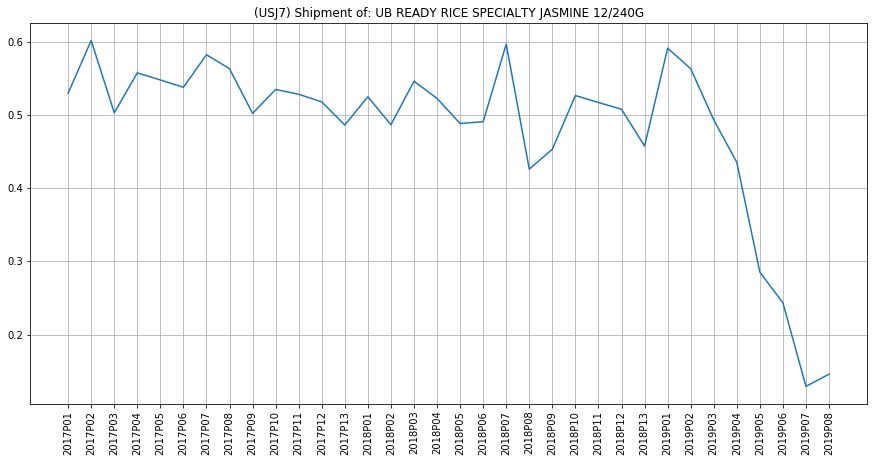

In [10]:
plt.figure(figsize = (15,7))
plt.plot(USJ70)
plt.title('(USJ7) Shipment of: UB READY RICE SPECIALTY JASMINE 12/240G')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

# 1) Moving Average / Rolling Mean

`DataFrame.rolling(window).mean()`: <br>
The wider the window - the smoother will be the trend. In the case of the very noisy data, which can be very often encountered in finance, this procedure can help to detect common patterns.

In [11]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    '''
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    
    '''
    
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Moving Average \n window size ={}".format(window))
    plt.plot(rolling_mean, "g", label = "Rolling Mean Trend")
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns = series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, 'ro', markersize = 10)
            print(series[anomalies.notna().values])
    plt.plot(series[window:], label="Actual Values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(rotation=90)


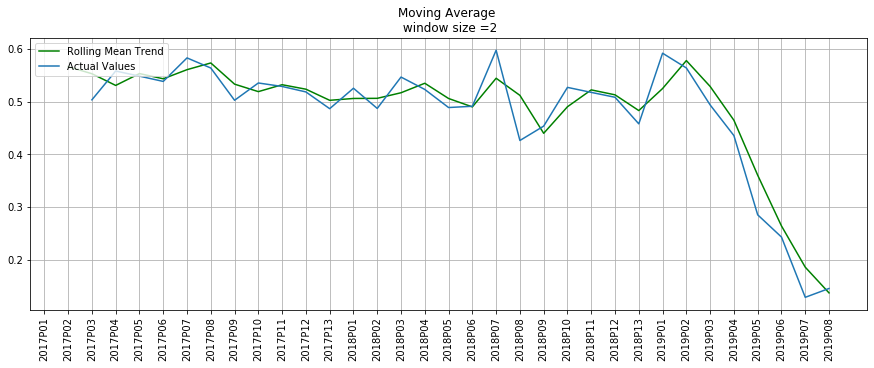

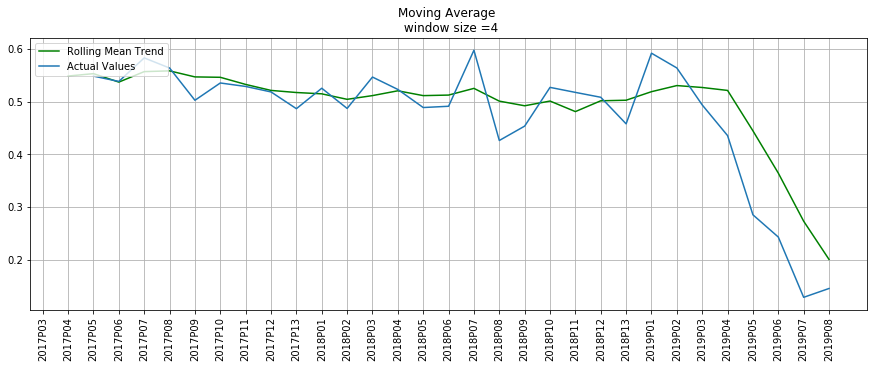

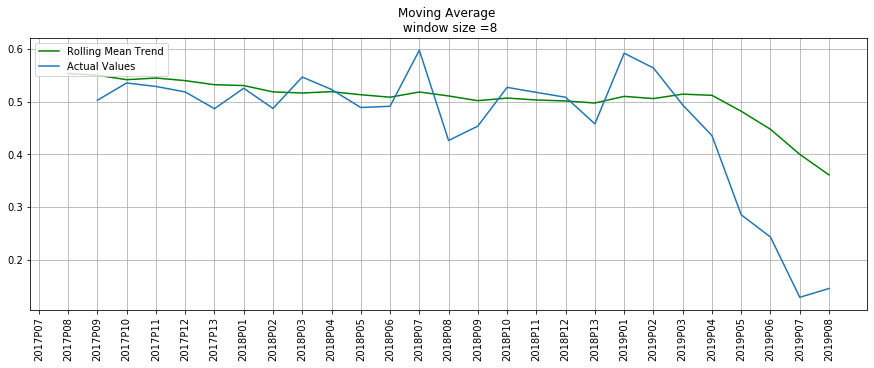

In [12]:
# smoothing by last 2 Periods
plotMovingAverage(USJ70,2)
# ....extra
plotMovingAverage(USJ70,4)
plotMovingAverage(USJ70,8)

Empty DataFrame
Columns: [USJ7]
Index: []


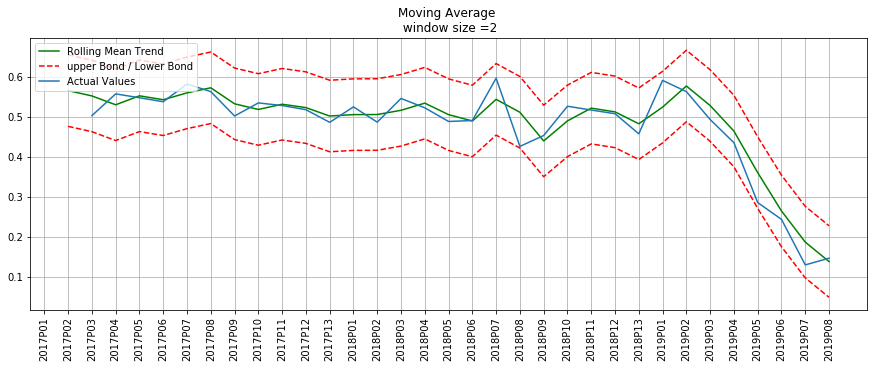

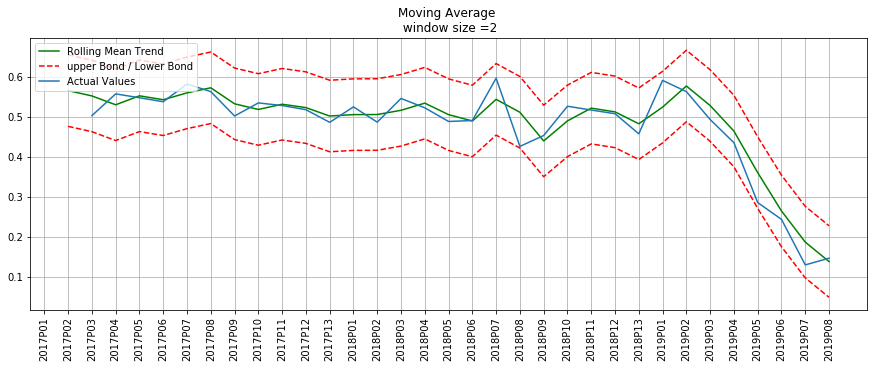

In [13]:
# Plotting Confidence Interval
plotMovingAverage(USJ70, 2,plot_intervals = True)
# Lets see if we catch anomaly
plotMovingAverage(USJ70, 2, plot_intervals=True, plot_anomalies=True)

# 1-a) Weighted Moving Average

**Weighted average**: is a simple modification of the moving average, inside of which observations have different weights summing up to one, usually more recent observations have greater weight.

In [14]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
        weight: List of weight ratio
    """
    result = 0.0
    weights.reverse()                  # reverses the list,inplace=True 
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)
  
weighted_average(USJ70, [0.6, 0.3, 0.1])

0.19937643688581697

# 2) Exponential Smoothing: A bit more complex model 

**Exponential smoothing**: <br>
And now let’s take a look at what happens if instead of weighting the last nn values of the time series we start weighting all available observations while exponentially decreasing weights as we move further back in historical data. There’s a formula of the simple exponential smoothing that will help us in that:

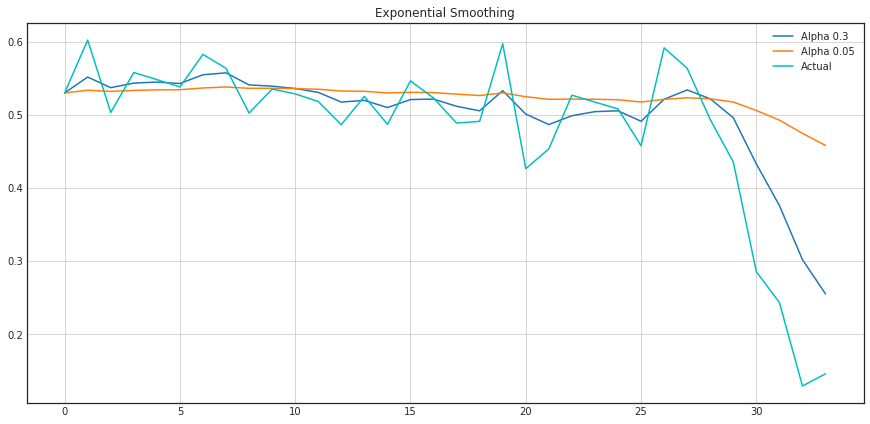

In [15]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
        
plotExponentialSmoothing(USJ70.USJ7, [0.3, 0.05])


# 2-a) Double exponential smoothing
#### Double Exponential Smoothing
A single future point prediction is not enough, so let's extend exponential smoothing so we can predict two future points.
<br>
Series decomposition should help us- obtain two components: intercept (also level) l and trend (also slope) b. We learn to predict intercept (or expected series value) using previous methods. We apply the same exponential smoothing to the trend, believing naively



As a result we get a set of functions. The first one describes intercept, as before it depends on the current value of the series, and the second term is now split into previous values of the level and of the trend. The second function describes trend — it depends on the level changes at the current step and on the previous value of the trend. In this case β coefficient is a weight in the exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

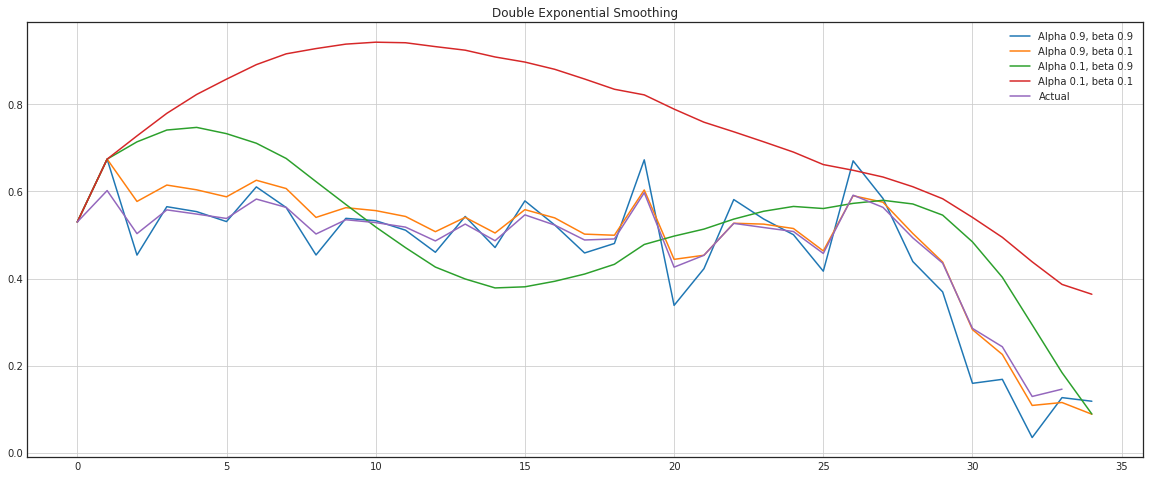

In [16]:

def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
        
plotDoubleExponentialSmoothing(USJ70.USJ7, alphas = [0.9, 0.1], betas=[0.9,0.1])


Now we have to tune two parameters — α and β. The former is responsible for the series smoothing around trend, and the latter for the smoothing of the trend itself. The bigger the values, the more weight the latest observations will have and the less smoothed the model series will be. Combinations of the parameters may produce really weird results, especially if set manually. We’ll look into choosing parameters automatically in a bit, immediately after triple exponential smoothing.

# 2-b) Triple Exponential Smoothing 
#### Triple Exponential Smoothing a.k.a Holt-Winters
The idea of this method is that we add another, third component **seasonality**. This means we shouldn't use the method if our time series do not have seasonality, which is not the case in our example. Seasonal components in the model will explain repeated variation around intercept and trend, and it will be described by the length of the season, in other words by the period after which variations repeat. For each observation in the season there's seperate component, for example, if the length of the season is 7 (weekly seasonality), we will have 7 seasonal components, one for each day of the week.

Intercept now depends on the current value of the series minus corresponding seasonal component, trend stays unchanged, and the seasonal component depends on the current value of the series minus intercept and on the previous value of the component. Please take into account that the component is smoothed through all the available seasons, for example, if we have a Monday component then it will only be averaged with other Mondays. You can read more on how averaging works and how initial approximation of the trend and seasonal components is done here. Now that we have seasonal component we can predict not one and not even two but arbitrary mm future steps which is very encouraging.
Below is the code for a triple exponential smoothing model, also known by the last names of its creators — Charles Holt and his student Peter Winters. Additionally Brutlag method was included into the model to build confidence intervals:


where T is the length of the season, d is the predicted deviation, and the other parameters were taken from the triple exponential smoothing. You can read more about the method and its applicability to anomalies detection in time series here.

In [17]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Time series cross validation
Before we start building model let’s talk first about how to estimate model parameters automatically. <br><br>
There’s nothing unusual here, as always we have to choose a loss function suitable for the task, that will tell us how close the model approximates data. Then using cross-validation we will evaluate our chosen loss function for given model parameters, calculate gradient, adjust model parameters and so forth, bravely descending to the global minimum of error. <br><br>
The question is how to do cross-validation on time series, because, you know, **time series do have time structure and one just can’t randomly mix values in a fold without preserving this structure, otherwise all time dependencies between observations will be lost.** That’s why we will have to use a bit more tricky approach to optimization of the model parameters, I don’t know if there’s an official name to it but on CrossValidated, where one can find all the answers but the Answer to the Ultimate Question of Life, the Universe, and Everything, “cross-validation on a rolling basis” was proposed as a name.<br><br>

The idea is rather simple — we train our model on a small segment of the time series, from the beginning until some t, make predictions for the next t+n steps and calculate an error. Then we expand our training sample until t+n value and make predictions from t+n until t+2∗n, and we continue moving our test segment of the time series until we hit the last available observation. As a result we have as many folds as many n will fit between the initial training sample and the last observation.

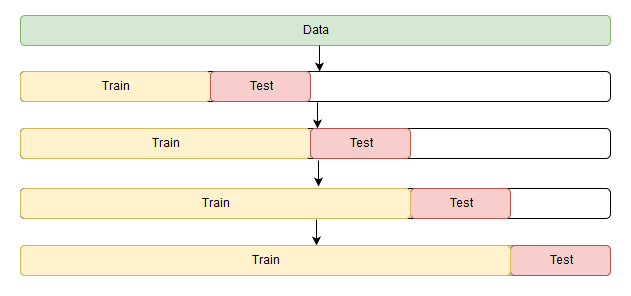

Now, knowing how to set cross-validation, we will find optimal parameters for the Holt-Winters model,
`slen=2`
recall that we have daily seasonality in ads, hence the `slen=24` parameter



In [18]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=2):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there’s a constraint on how big smoothing parameters could be, each of them is in the range from 0 to 1, therefore to minimize loss function we have to choose an algorithm that supports constraints on model parameters, in our case — Truncated Newton conjugate gradient.

In [21]:
%%time
from scipy.optimize import minimize   
data = USJ70.USJ7[:-7] # leave some data for testing

# initializing model parameters alpha, beta, and gamma
x = [0,0,0]

# minimizing the loss function
opt = minimize(timeseriesCVscore, x0=x,
              args=(data, mean_squared_log_error),
              method = "TNC", bounds = ((0,1),(0,1),(0,1))
              )
# take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting the next 50 hours
model = HoltWinters(data, slen = 12,
                   alpha = alpha_final,
                   beta= beta_final,
                   gamma = gamma_final,
                   n_preds = 7,
                   scaling_factor = 2)

model.triple_exponential_smoothing()

0.15469756420469088 0.2815781024867437 0.0
Wall time: 1.04 s


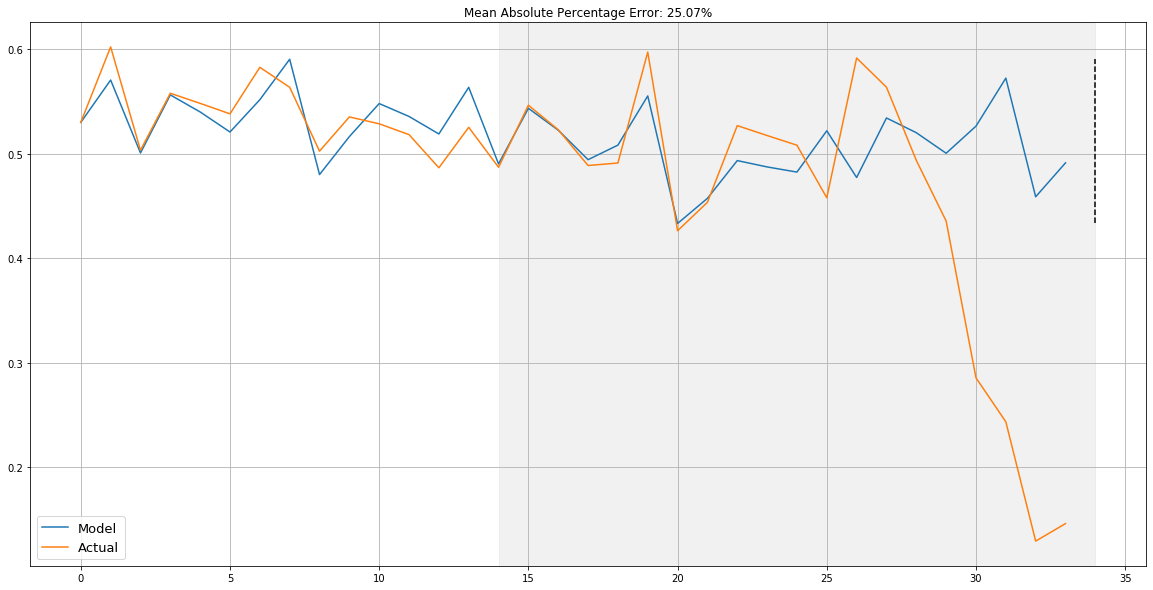

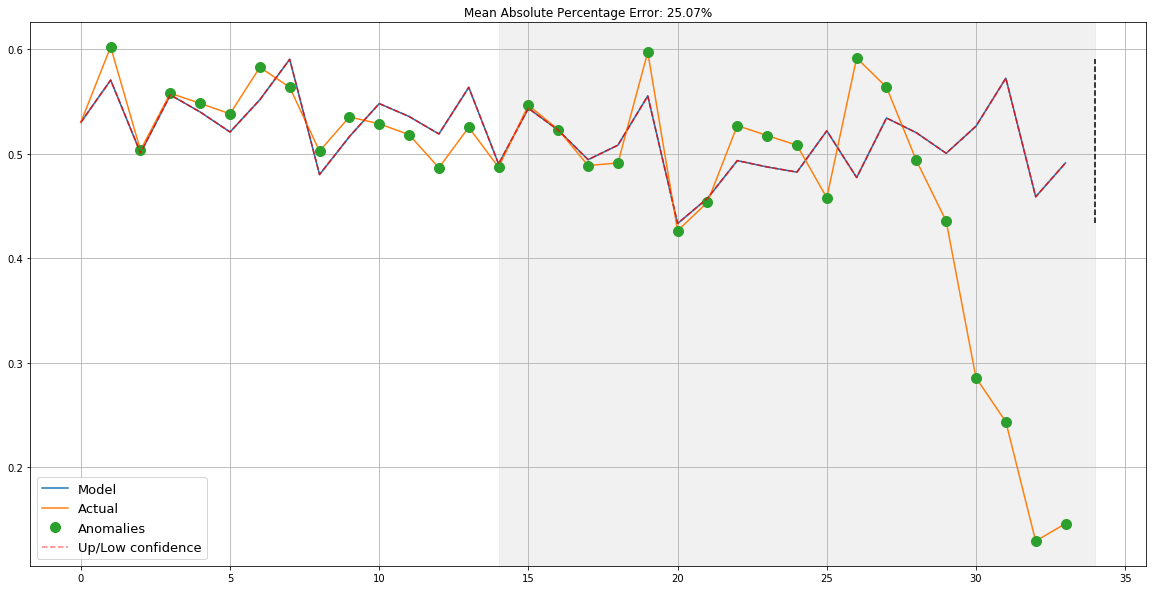

In [22]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(USJ70.USJ7)
plotHoltWinters(USJ70.USJ7, plot_intervals=True, plot_anomalies=True)

# Conclusion:

Forecasting Order Qty is not so simple using Holts-winter. I should go by ratios for simplicity and big fluctuations

In [238]:
temp = df[df['Description'].isin([Top3SKU[0]])].pivot_table(values='Order qty', index=['Actual Goods Issue Year Period','Description','Plant']\
                                                     ,aggfunc = lambda x: x.sum()).fillna(0)

temp.groupby(level=0).transform(lambda x: x/x.sum())

Order qty
Actual Goods Issue Year Period Description                             Plant           
2017P01                        UB READY RICE SPECIALTY JASMINE 12/240G USC8    0.258795
                                                                       USD3    0.093651
                                                                       USE2    0.063867
                                                                       USJ7    0.529913
                                                                       USV2    0.041271
                                                                       USV6    0.012503
2017P02                        UB READY RICE SPECIALTY JASMINE 12/240G USC8    0.183348
                                                                       USD3    0.077216
                                                                       USE2    0.080199
                                                                       USJ7    0.602128
                                                                       USV2    0.047317
                                                                       USV6    0.009792
2017P03                        UB READY RICE SPECIALTY JASMINE 12/240G USC8    0.251164
                                                                       USD3    0.125482
                                                                       USE2    0.063872
                                                                       USJ7    0.503225
                                                                       USV2    0.044294
                                                                       USV6    0.011963
2017P04                        UB READY RICE SPECIALTY JASMINE 12/240G USC8    0.187956
                                                                       USD3    0.111910
                                                                       USE2    0.071640
                                                                       USJ7    0.557777
                                                                       USV2    0.051893
                                                                       USV6    0.018825
2017P05                        UB READY RICE SPECIALTY JASMINE 12/240G USC8    0.208061
                                                                       USD3    0.109352
                                                                       USE2    0.086923
                                                                       USJ7    0.548109
                                                                       USV2    0.031438
                                                                       USV6    0.016116
2017P06                        UB READY RICE SPECIALTY JASMINE 12/240G USC8    0.221652
                                                                       USD3    0.115953
                                                                       USE2    0.066178
                                                                       USJ7    0.538078
                                                                       USV2    0.041771
                                                                       USV6    0.016368
2017P07                        UB READY RICE SPECIALTY JASMINE 12/240G USC8    0.172453
                                                                       USD3    0.108950
                                                                       USE2    0.079247
                                                                       USJ7    0.582607
                                                                       USV2    0.040651
                                                                       USV6    0.016092
2017P08                        UB READY RICE SPECIALTY JASMINE 12/240G USC8    0.203028
                                                                       USD3    0.103655
                              

In [26]:
df[df['Description'].isin([Top3SKU[0]])].pivot_table(values='Order qty',index=['Sold to Party Name','Plant'], aggfunc = lambda x: x.sum()).sort_values(by='Order qty',ascending=False)

,,Order qty
Sold to Party Name,Plant,
WAL-MART (EXCL HAWAII),USJ7,641272
C & S NORTHEAST (POI),USC8,213593
PUBLIX,USJ7,150549
PEYTONS 1 (POI),USE2,107360
H E BUTT GROC CO,USJ7,96369
PEYTONS 1 (POI),USJ7,80033
WAKEFERN FOOD CORP (POI),USC8,70110
KING SOOPERS (POI),USJ7,61488
FOOD LION (POI),USJ7,57153


In [83]:
temp = df[df['Description'].isin(Top3SKU)].pivot_table(values='Order qty', index=['Actual Goods Issue Year Period','Description']\
                                                     ,columns='DC',aggfunc = lambda x: x.sum()).fillna(0)
temp = temp.loc[:,temp.columns].div(temp.sum(axis=1), axis=0)
temp

DC                                                                          USC8  \
Actual Goods Issue Year Period Description                                         
2017P01                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.162389   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.276633   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.264364   
2017P02                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.171756   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.227206   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.239865   
2017P03                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.208660   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.303715   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.269164   
2017P04                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.152415   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.192186   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.212838   
2017P05                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.184436   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.238183   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.212445   
2017P06                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.143667   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.232678   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.168829   
2017P07                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.111753   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.171716   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.171909   
2017P08                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.170097   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.231469   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.181392   
2017P09                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.198986   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.195501   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.262864   
2017P10                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.160655   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.253952   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.201180   
2017P11                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.133675   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.231045   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.168162   
2017P12                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.201929   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.271824   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.270511   
2017P13                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.195916   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.230906   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.247627   
2018P01                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.175021   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.263377   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.247801   
2018P02                        UB READY RICE SPANISH STYLE 12/8.8OZ     0.144114   
                               UB READY RICE SPECIALTY JASMINE 12/240G  0.216054   
                               UB RR WHOLE GRAIN BROWN 12/8.8OZ         0.199175   
2018P03                        UB READY RICE SPANISH

Description
UB READY RICE SPANISH STYLE 12/8.8OZ       AxesSubplot(0.125,0.125;0.775x0.755)
UB READY RICE SPECIALTY JASMINE 12/240G    AxesSubplot(0.125,0.125;0.775x0.755)
UB RR WHOLE GRAIN BROWN 12/8.8OZ           AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

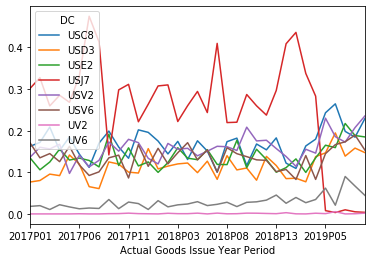

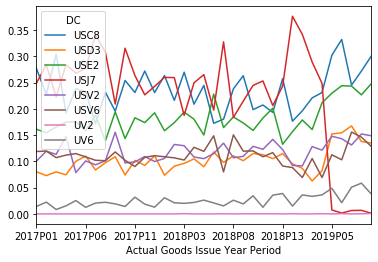

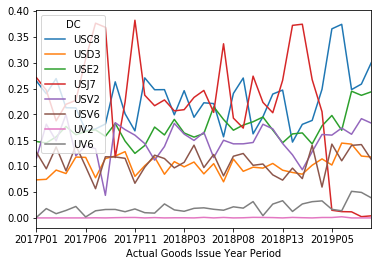

In [84]:
temp.reset_index(['Description']).groupby('Description').plot()

In [98]:
df[df['Sold to Party Name']=='WAL-MART (EXCL HAWAII)'].groupby(['Plant']).count()

,Unnamed: 0,Actual Goods Issue Year Period,Sold-to party,Sold to Party Name,Customer Hierarchy,Ship-to party,Ship to Party Name,Location (City),Region,Region Name,Postal Code,Sales Org,Sales Org. Name,Distr Chan,Distr. Channel Name,Division,Division Name,Sales document,Document date,Plant Name,Postal Code.1,Location (City).1,Region.1,Region Plant Name,Del No.,Material,Description,Order qty,Gds mvt qty,Gross weight ord (Lb),Gross Weight Dlvrd (Lb),GSV Delivered,DD_week_num,DD_month,DD_year,DC,Parent Account,Priority,Correct_DC,approx_unit_lb
Plant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
USE2,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715,4715
USJ7,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586,194586
USV6,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283


(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 7 Text xticklabel objects>)

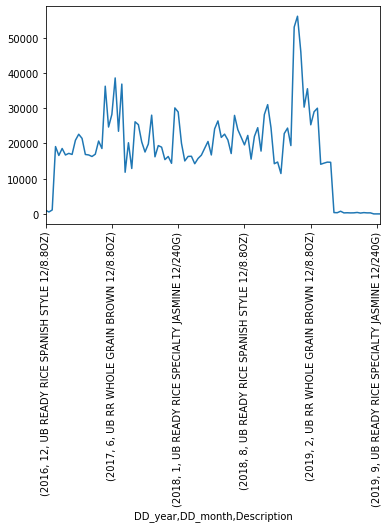

In [75]:
df[df['Description'].isin(Top3SKU)].pivot_table(values='Order qty', index=['DD_year','DD_month','Description']\
                                                     ,columns='DC',aggfunc = lambda x: x.sum()).fillna(0)['USJ7'].plot()
plt.xticks(rotation=90)

# ARIMA

Three basic criterion for a series to be ***Stationary***

1) The **mean** of the series should not be a function of time, but be a **constant**. Graph on the left satisfies, but the graph in red has a time dependence.

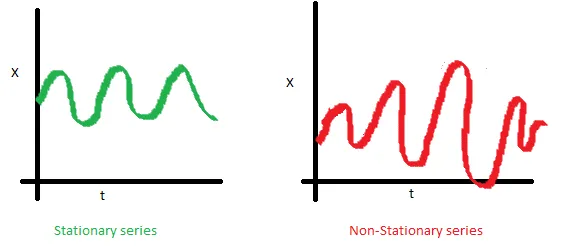


2) The **variance** of the series should not be a function of time. THis property is known as *homoscedacity*. Notice the varying spread of distribution in the right graph. 

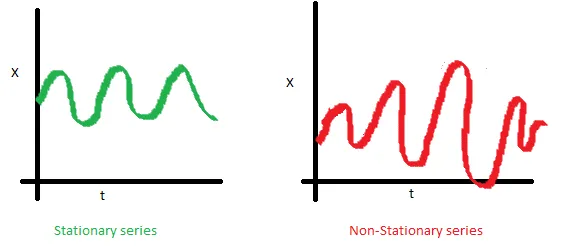

3) The **covariance** of the ith term and the (i+m)th term should not be a function of time. In the following graph, the spread becomes closer as the time increases in the right. Hence, the covariance is **not constant** with time for the right graph.


# Why do we care about Stationarity?


In [7]:
df.columns

Index(['Unnamed: 0', 'Actual Goods Issue Year Period', 'Sold-to party',
       'Sold to Party Name', 'Customer Hierarchy', 'Ship-to party',
       'Ship to Party Name', 'Location (City)', 'Region', 'Region Name',
       'Postal Code', 'Sales Org', 'Sales Org. Name', 'Distr Chan',
       'Distr. Channel Name', 'Division', 'Division Name', 'Sales document',
       'Document date', 'Plant', 'Plant Name', 'Postal Code.1',
       'Location (City).1', 'Region.1', 'Region Plant Name', 'Del No.',
       'Material', 'Description', 'Order qty', 'Gds mvt qty',
       'Gross weight ord (Lb)', 'Gross Weight Dlvrd (Lb)', 'GSV Delivered',
       'DD_week_num', 'DD_month', 'DD_year', 'DC', 'Parent Account',
       'Priority', 'Correct_DC', 'approx_unit_lb'],
      dtype='object')

In [5]:
len(df['Ship to Party Name'].unique())

674

In [22]:
len(df['Description'].unique())
import numpy as np
pd.options.display.float_format = '{:,.4f}'.format